<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm.
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 45% Correct construction of loss function in a loss class
* 10% Correct initialization and optimization of image variable in a dataset class
* 10% Awesome looking final image

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [0]:

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving content.png to content (1).png

Upload Style Image


Saving style.png to style.png
Content Path: content.png
Style Path: style.png


In [ ]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

**DONE:**



In [0]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = torch.tensor(mean).view(-1, 1, 1)
      self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # the model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [0]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

# Choose the layers to use for style and content transfer

# Create the vgg network in eval mode
#  with our forward method that returns the outputs of the intermediate layers we requested

# Cache the outputs of the content and style layers for their respective images

{0, 2, 5, 7, 10}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:21<00:00, 26089131.27it/s]


___

### Part 2
Create a method to turn a tensor to an image to display

**TODO:**

**DONE:**

* Display the style tensor and content tensor transformed back to an image

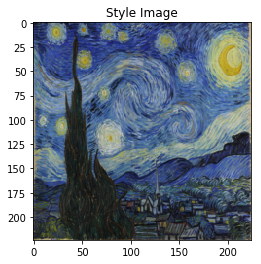

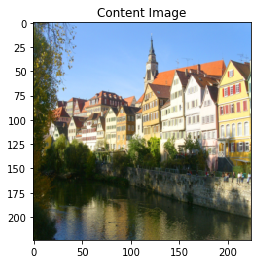

In [0]:
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 3
Create a classes for the style and content loss

**TODO:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

**DONE:**


In [0]:
def gram_matrix(input):
   pass
  
class ContentLoss(nn.Module):
  pass
    
class StyleLoss(nn.Module):
  pass

# Instantiate a content loss module for each content layer 
#  with the content reference image outputs for that layer for comparison

# Instantiate a sytle loss module for each style layer 
#  with the style reference image outputs for that layer for comparison


{0: StyleLoss(), 2: StyleLoss(), 5: StyleLoss(), 7: StyleLoss(), 10: StyleLoss()}
{7: ContentLoss()}


___

### Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer with learning rate of .1
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

**DONE:**



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Step 50:
Style Loss: 55.919987 Content Loss: 21.382088

Step 100:
Style Loss: 20.928503 Content Loss: 18.493711

Step 150:
Style Loss: 11.869914 Content Loss: 15.925084

Step 200:
Style Loss: 7.314709 Content Loss: 13.905386

Step 250:
Style Loss: 4.800727 Content Loss: 12.303100

Step 300:
Style Loss: 3.363420 Content Loss: 11.058169

Step 350:
Style Loss: 2.516240 Content Loss: 10.089510

Step 400:
Style Loss: 2.004870 Content Loss: 9.334830

Step 450:
Style Loss: 1.685497 Content Loss: 8.739787

Step 500:
Style Loss: 1.475811 Content Loss: 8.262876



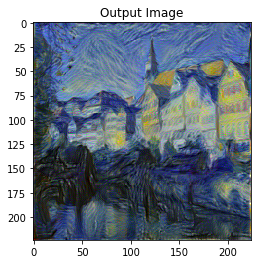

In [0]:
# Start with a copy of the content image

# Run the optimizer on the images to change the image
#  using the loss of the style and content layers
#  to backpropagate errors 
  
# Show the image